In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import KeyedVectors

## Task 1 - Data Preparation

In [2]:
df = pd.read_csv('./movies.csv')

In [3]:
# Using only columns: genre, keywords, tagline, overview, voting_average
df = df[['genres', 'keywords', 'tagline', 'overview', 'vote_average']]

In [4]:
# Perform text preprocessing: lowercase; remove URLs, punctuation, and numbers; tokenize; optional lemmatization.
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    if pd.isna(text):
        return []
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens
df['processed_genres'] = df['genres'].apply(preprocess_text)
df['processed_keywords'] = df['keywords'].apply(preprocess_text)
df['processed_tagline'] = df['tagline'].apply(preprocess_text)
df['processed_overview'] = df['overview'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/devrajsinhgohil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/devrajsinhgohil/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/devrajsinhgohil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/devrajsinhgohil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Remove null values and duplicates from the dataset.
df.dropna(inplace=True)

In [6]:
df.shape

(3759, 9)

In [7]:
# Create reproducible train/validation/test splits (suggestion: 70/15/15).
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

## Task 2 - GloVe Embedding Pipeline

In [8]:
# Download and load pretrained GloVe vectors (100D or 200D; clearly state which dimension you use). I am using 200D GloVe vectors using gensim.
glove_file = '/Users/devrajsinhgohil/Desktop/DL/wiki_giga_2024_200_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt'
glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False,no_header=True)

In [9]:
# Report embedding coverage: percentage of unique dataset tokens present in GloVe.
def calculate_embedding_coverage(tokens, glove_model):
    unique_tokens = set(tokens)
    covered_tokens = [token for token in unique_tokens if token in glove_model]
    coverage = len(covered_tokens) / len(unique_tokens) * 100
    return coverage
all_tokens = []
for col in ['processed_genres', 'processed_keywords', 'processed_tagline', 'processed_overview']:
    all_tokens.extend(train_df[col].explode().unique())
coverage = calculate_embedding_coverage(all_tokens, glove_model)
print(f'Embedding coverage: {coverage:.2f}%')

Embedding coverage: 93.02%


In [10]:
# Construct document embeddings using TF-IDF weighted averaging of GloVe word vectors.
from sklearn.feature_extraction.text import TfidfVectorizer
def get_document_embedding(tokens, glove_model, tfidf_vectorizer):
    tfidf_weights = tfidf_vectorizer.transform([' '.join(tokens)]).toarray()[0]
    embedding = np.zeros(glove_model.vector_size)
    for token, weight in zip(tfidf_vectorizer.get_feature_names_out(), tfidf_weights):
        if token in glove_model:
            embedding += weight * glove_model[token]
    return embedding
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(train_df['processed_overview'].apply(lambda x: ' '.join(x)))
train_df['document_embedding'] = train_df['processed_overview'].apply(lambda x: get_document_embedding(x, glove_model, tfidf_vectorizer))
val_df['document_embedding'] = val_df['processed_overview'].apply(lambda x: get_document_embedding(x, glove_model, tfidf_vectorizer))
test_df['document_embedding'] = test_df['processed_overview'].apply(lambda x: get_document_embedding(x, glove_model, tfidf_vectorizer))

In [11]:
# Keep embedding dimensionality consistent across all experiments.
assert glove_model.vector_size == 200, f"Expected 200D embeddings, got {glove_model.vector_size}D"

## Task 3 - Model A: Rating Prediction (Regression)

In [12]:
# Select one text column as input (overview OR tagline OR keywords). I will use overview and tagline for input features, and vote_average as the target variable.
train_df['input_features'] = train_df['processed_overview'] + train_df['processed_tagline']
val_df['input_features'] = val_df['processed_overview'] + val_df['processed_tagline']
test_df['input_features'] = test_df['processed_overview'] + test_df['processed_tagline']
train_df['target'] = train_df['vote_average']
val_df['target'] = val_df['vote_average']
test_df['target'] = test_df['vote_average']

In [13]:
# Train a neural regression model to predict voting_average from the document embedding. I am using pytorch to create model for this. also will use validation loss while training the model to prevent overfitting. 
# Will use give the feedback from validation loss after every epoch. 
# Will save the current best model based on validation loss, and report test performance using the best saved model.
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
class MovieDataset(Dataset):
    def __init__(self, df):
        self.embeddings = np.stack(df['document_embedding'].values)
        self.targets = df['target'].values.astype(np.float32)
    def __len__(self):
        return len(self.targets)
    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)


In [14]:
train_dataset = MovieDataset(train_df)
val_dataset = MovieDataset(val_df)
test_dataset = MovieDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [15]:

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.squeeze()
    


In [16]:
# Training loop with validation and model checkpointing
model = RegressionModel(input_dim=glove_model.vector_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
best_val_loss = float('inf')
for epoch in range(3000):
    model.train()
    train_loss = 0.0
    for embeddings, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * embeddings.size(0)
    train_loss /= len(train_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for embeddings, targets in val_loader:
            outputs = model(embeddings)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * embeddings.size(0)
    val_loss /= len(val_loader.dataset)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1, Train Loss: 8.5509, Val Loss: 3.0680
Epoch 2, Train Loss: 2.4699, Val Loss: 2.3670
Epoch 3, Train Loss: 2.0833, Val Loss: 2.1279
Epoch 4, Train Loss: 1.8164, Val Loss: 1.9435
Epoch 5, Train Loss: 1.6024, Val Loss: 1.7951
Epoch 6, Train Loss: 1.3987, Val Loss: 1.6644
Epoch 7, Train Loss: 1.2264, Val Loss: 1.5474
Epoch 8, Train Loss: 1.0980, Val Loss: 1.4255
Epoch 9, Train Loss: 0.9673, Val Loss: 1.3772
Epoch 10, Train Loss: 0.8552, Val Loss: 1.2853
Epoch 11, Train Loss: 0.7789, Val Loss: 1.2206
Epoch 12, Train Loss: 0.7189, Val Loss: 1.1916
Epoch 13, Train Loss: 0.6983, Val Loss: 1.1302
Epoch 14, Train Loss: 0.6298, Val Loss: 1.1292
Epoch 15, Train Loss: 0.6027, Val Loss: 1.0907
Epoch 16, Train Loss: 0.5627, Val Loss: 1.1736
Epoch 17, Train Loss: 0.5438, Val Loss: 1.0477
Epoch 18, Train Loss: 0.5173, Val Loss: 1.0701
Epoch 19, Train Loss: 0.4932, Val Loss: 1.0439
Epoch 20, Train Loss: 0.4678, Val Loss: 1.0785
Epoch 21, Train Loss: 0.4521, Val Loss: 1.0675
Epoch 22, Train Loss: 

In [17]:
# Saved model with validation loss
print(f'Best validation loss: {best_val_loss:.4f}')

Best validation loss: 1.0362


In [18]:
# Report MSE and RMSE on the test set.
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss = 0.0
with torch.no_grad():
    for embeddings, targets in test_loader:
        outputs = model(embeddings)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * embeddings.size(0)
test_loss /= len(test_loader.dataset)
rmse = np.sqrt(test_loss)
print(f'Test MSE: {test_loss:.4f}, Test RMSE: {rmse:.4f}')

Test MSE: 1.1849, Test RMSE: 1.0885


## Task 4 - Model B: Genre Prediction (Multi-Label Classification)

In [19]:
# Select one text column as input (overview OR tagline OR keywords). I will use overview and keywords for input features, and vote_average as the target variable.
train_df['input_features'] = train_df['processed_overview'] + train_df['processed_keywords']
val_df['input_features'] = val_df['processed_overview'] + val_df['processed_keywords']
test_df['input_features'] = test_df['processed_overview'] + test_df['processed_keywords']
train_df['target'] = train_df['vote_average']
val_df['target'] = val_df['vote_average']
test_df['target'] = test_df['vote_average']

In [ ]:
# Train a multi-label classifier to predict genres. I will use pytorch to create model for this. also will use validation loss while training the model to prevent overfitting. 
# Use sigmoid outputs and an appropriate loss such as BCEWithLogitsLoss.
# Creating multi-label binarizer for genres
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
train_genres = mlb.fit_transform(train_df['processed_genres'])
val_genres = mlb.transform(val_df['processed_genres'])
test_genres = mlb.transform(test_df['processed_genres'])


In [25]:
# creating model dataset and dataloader for multi-label classification
class GenreDataset(Dataset):
    def __init__(self, df, genre_labels):
        self.embeddings = np.stack(df['document_embedding'].values)
        self.labels = genre_labels.astype(np.float32)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)
train_genre_dataset = GenreDataset(train_df, train_genres)
val_genre_dataset = GenreDataset(val_df, val_genres)
test_genre_dataset = GenreDataset(test_df, test_genres)
train_genre_loader = DataLoader(train_genre_dataset, batch_size=32, shuffle=True)
val_genre_loader = DataLoader(val_genre_dataset, batch_size=32)
test_genre_loader = DataLoader(test_genre_dataset, batch_size=32)

In [26]:
# A complex multi-label classification model with multiple layers, dropout, and batch normalization. I will use a simple feedforward neural network with two hidden layers, ReLU activations, dropout for regularization, and batch normalization to improve training stability.
class MultiLabelClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultiLabelClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, output_dim)
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return torch.sigmoid(x)

In [27]:
# Training loop with validation and model checkpointing for multi-label classification
model = MultiLabelClassifier(input_dim=glove_model.vector_size, output_dim=train_genres.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
best_val_loss = float('inf')
for epoch in range(3000):
    model.train()
    train_loss = 0.0
    for embeddings, labels in train_genre_loader:
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * embeddings.size(0)
    train_loss /= len(train_genre_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for embeddings, labels in val_genre_loader:
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * embeddings.size(0)
    val_loss /= len(val_genre_loader.dataset)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_multilabel_model.pth')

Epoch 1, Train Loss: 0.7795, Val Loss: 0.7367
Epoch 2, Train Loss: 0.7030, Val Loss: 0.7045
Epoch 3, Train Loss: 0.6959, Val Loss: 0.6973
Epoch 4, Train Loss: 0.6933, Val Loss: 0.6944
Epoch 5, Train Loss: 0.6917, Val Loss: 0.6927
Epoch 6, Train Loss: 0.6906, Val Loss: 0.6917
Epoch 7, Train Loss: 0.6895, Val Loss: 0.6911
Epoch 8, Train Loss: 0.6888, Val Loss: 0.6906
Epoch 9, Train Loss: 0.6882, Val Loss: 0.6907
Epoch 10, Train Loss: 0.6879, Val Loss: 0.6909
Epoch 11, Train Loss: 0.6877, Val Loss: 0.6906
Epoch 12, Train Loss: 0.6873, Val Loss: 0.6903
Epoch 13, Train Loss: 0.6867, Val Loss: 0.6906
Epoch 14, Train Loss: 0.6868, Val Loss: 0.6902
Epoch 15, Train Loss: 0.6864, Val Loss: 0.6903
Epoch 16, Train Loss: 0.6864, Val Loss: 0.6901
Epoch 17, Train Loss: 0.6862, Val Loss: 0.6908
Epoch 18, Train Loss: 0.6859, Val Loss: 0.6905
Epoch 19, Train Loss: 0.6860, Val Loss: 0.6902
Epoch 20, Train Loss: 0.6855, Val Loss: 0.6911
Epoch 21, Train Loss: 0.6857, Val Loss: 0.6902
Epoch 22, Train Loss: 

In [28]:
# Model with best validation loss
print(f'Best validation loss: {best_val_loss:.4f}')

Best validation loss: 0.6898


In [29]:
# Report micro-F1 and macro-F1; additionally report Hamming loss or Jaccard score.
from sklearn.metrics import f1_score, hamming_loss, jaccard_score
model.load_state_dict(torch.load('best_multilabel_model.pth'))
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for embeddings, labels in test_genre_loader:
        outputs = model(embeddings)
        preds = (outputs > 0.5).float()
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)
micro_f1 = f1_score(all_labels, all_preds, average='micro')
macro_f1 = f1_score(all_labels, all_preds, average='macro')
hamming = hamming_loss(all_labels, all_preds)
jaccard = jaccard_score(all_labels, all_preds, average='samples')
print(f'Micro-F1: {micro_f1:.4f}, Macro-F1: {macro_f1:.4f}, Hamming Loss: {hamming:.4f}, Jaccard Score: {jaccard:.4f}')

Micro-F1: 0.3268, Macro-F1: 0.0944, Hamming Loss: 0.1086, Jaccard Score: 0.2520


/Users/devrajsinhgohil/Desktop/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [49]:
# Repeat for at least two different single-text inputs and compare results. showing the name of genres predicted for each text. I will use the same model to predict genres for two different texts and and compare the results.
single_texts = [
    "After a failed physics experiment fractures time within a small coastal town, a reclusive engineer begins experiencing brief glimpses of future disasters — each more catastrophic than the last. As reality subtly shifts around him, he realizes his actions in the present are accelerating the collapse of time itself. With the town trapped in overlapping timelines, he must choose between saving the people he loves or restoring the natural order of the universe.",
    "A young corporate analyst becomes obsessed with a mysterious, unlisted floor in his office building that appears only at night. As he investigates, he uncovers evidence suggesting the company can predict — and manipulate — the fate of its employees. With time running out and his own future in question, he must determine whether the threat is a calculated conspiracy or the unraveling of his own mind."
]
for text in single_texts:
    embedding = get_document_embedding(preprocess_text(text), glove_model, tfidf_vectorizer)
    embedding_tensor = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        output = model(embedding_tensor)
        pred = (output > 0.5).float()
        print(f"Text: {text}")
        print(f"Predicted genres: {pred}")
        print(f"Predicted genre names: {[mlb.classes_[i] for i in range(len(pred[0])) if pred[0][i] == 1]}")

Text: After a failed physics experiment fractures time within a small coastal town, a reclusive engineer begins experiencing brief glimpses of future disasters — each more catastrophic than the last. As reality subtly shifts around him, he realizes his actions in the present are accelerating the collapse of time itself. With the town trapped in overlapping timelines, he must choose between saving the people he loves or restoring the natural order of the universe.
Predicted genres: tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]])
Predicted genre names: ['drama']
Text: A young corporate analyst becomes obsessed with a mysterious, unlisted floor in his office building that appears only at night. As he investigates, he uncovers evidence suggesting the company can predict — and manipulate — the fate of its employees. With time running out and his own future in question, he must determine whether the threat is a calculated conspiracy

## Task 5 - Frequent Words per Genre

In [51]:
# For each genre, compute the top 10 most frequent content words after preprocessing. useing the processed_overview column for this analysis.
from collections import Counter
genre_word_counts = {}
for genres, overview in zip(train_df['processed_genres'], train_df['processed_overview']):
    for genre in genres:
        if genre not in genre_word_counts:
            genre_word_counts[genre] = Counter()
        genre_word_counts[genre].update(overview)
top_words_per_genre = {genre: counts.most_common(10) for genre, counts in genre_word_counts.items()}
for genre, top_words in top_words_per_genre.items():
    print(f"Genre: {genre}")
    print(f"Top 10 words: {top_words}")

Genre: fantasy
Top 10 words: [('world', 65), ('find', 64), ('life', 53), ('must', 42), ('young', 42), ('new', 39), ('evil', 39), ('love', 32), ('take', 29), ('time', 28)]
Genre: comedy
Top 10 words: [('life', 207), ('find', 191), ('one', 160), ('new', 160), ('friend', 160), ('get', 144), ('two', 131), ('love', 123), ('family', 105), ('take', 102)]
Genre: drama
Top 10 words: [('life', 333), ('find', 180), ('one', 177), ('young', 170), ('story', 167), ('new', 165), ('love', 158), ('family', 157), ('man', 147), ('world', 142)]
Genre: history
Top 10 words: [('war', 31), ('story', 30), ('world', 26), ('life', 23), ('man', 17), ('film', 15), ('king', 15), ('army', 15), ('love', 12), ('find', 12)]
Genre: music
Top 10 words: [('life', 26), ('one', 26), ('new', 22), ('band', 17), ('story', 16), ('world', 15), ('dancer', 14), ('music', 14), ('dream', 14), ('take', 13)]
Genre: animation
Top 10 words: [('world', 38), ('find', 34), ('friend', 28), ('life', 27), ('young', 25), ('new', 25), ('must', 

In [53]:
# For each genre, compute the bottom 10 least frequent words (apply a minimum frequency threshold such as ≥ 3).
genre_word_counts = {}
for genres, overview in zip(train_df['processed_genres'], train_df['processed_overview']):
    for genre in genres:
        if genre not in genre_word_counts:
            genre_word_counts[genre] = Counter()
        genre_word_counts[genre].update(overview)

bottom_words_per_genre = {}
for genre, counts in genre_word_counts.items():
    filtered_counts = {word: count for word, count in counts.items() if count >= 3}
    sorted_words = sorted(filtered_counts.items(), key=lambda x: x[1])
    bottom_words_per_genre[genre] = sorted_words[:10] if len(sorted_words) >= 10 else sorted_words
for genre, bottom_words in bottom_words_per_genre.items():
    print(f"Genre: {genre}")
    print(f"Bottom 10 words (≥3 occurrences): {bottom_words}")

Genre: fantasy
Bottom 10 words (≥3 occurrences): [('happens', 3), ('zeus', 3), ('stone', 3), ('limit', 3), ('already', 3), ('next', 3), ('wake', 3), ('longer', 3), ('alternate', 3), ('suburban', 3)]
Genre: comedy
Bottom 10 words (≥3 occurrences): [('brook', 3), ('price', 3), ('satisfy', 3), ('script', 3), ('lying', 3), ('sweetheart', 3), ('exists', 3), ('alternate', 3), ('furious', 3), ('burn', 3)]
Genre: drama
Bottom 10 words (≥3 occurrences): [('peer', 3), ('remarkable', 3), ('election', 3), ('turkish', 3), ('activity', 3), ('entangled', 3), ('lavish', 3), ('alternate', 3), ('roof', 3), ('knocked', 3)]
Genre: history
Bottom 10 words (≥3 occurrences): [('told', 3), ('secret', 3), ('join', 3), ('begin', 3), ('real', 3), ('brilliant', 3), ('government', 3), ('half', 3), ('name', 3), ('indian', 3)]
Genre: music
Bottom 10 words (≥3 occurrences): [('former', 3), ('professional', 3), ('teach', 3), ('based', 3), ('man', 3), ('th', 3), ('canada', 3), ('chronicle', 3), ('theater', 3), ('record

In [61]:
# Present results clearly in tables and briefly interpret patterns.
top_words_df = pd.DataFrame.from_dict(
    {genre: [word for word, count in words] 
     for genre, words in top_words_per_genre.items()},
    orient='index'
)
top_words_df

,0,1,2,3,4,5,6,7,8,9
fantasy,world,find,life,must,young,new,evil,love,take,time
comedy,life,find,one,new,friend,get,two,love,family,take
drama,life,find,one,young,story,new,love,family,man,world
history,war,story,world,life,man,film,king,army,love,find
music,life,one,new,band,story,world,dancer,music,dream,take
animation,world,find,friend,life,young,new,must,one,set,get
family,find,world,life,friend,young,new,must,get,one,family
crime,one,life,get,find,family,new,two,police,agent,drug
thriller,life,find,one,new,world,man,family,must,young,get
romance,love,life,find,woman,one,new,young,friend,get,two


In [62]:
bottom_words_df = pd.DataFrame.from_dict(
    {genre: [word for word, count in words] 
     for genre, words in bottom_words_per_genre.items()},
    orient='index'
)
bottom_words_df

,0,1,2,3,4,5,6,7,8,9
fantasy,happens,zeus,stone,limit,already,next,wake,longer,alternate,suburban
comedy,brook,price,satisfy,script,lying,sweetheart,exists,alternate,furious,burn
drama,peer,remarkable,election,turkish,activity,entangled,lavish,alternate,roof,knocked
history,told,secret,join,begin,real,brilliant,government,half,name,indian
music,former,professional,teach,based,man,th,canada,chronicle,theater,record
animation,could,jon,effort,survival,specie,orphaned,valley,live,four,different
family,lover,effort,competition,furious,rather,million,map,enters,fortune,hire
crime,legal,immigrant,porter,avoid,possible,entangled,human,court,record,elaborate
thriller,flash,porter,sort,entangled,fix,court,record,used,alaska,actual
romance,lifestyle,record,used,notorious,case,although,destined,patient,almásy,desert


## Task 6 - Genre-Indicative Words Using TF-IDF

In [63]:
# Use TF-IDF combined with a linear model (e.g., logistic regression per genre) to identify indicative words.
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['processed_overview'].apply(lambda x: ' '.join(x)))
X_val_tfidf = tfidf_vectorizer.transform(val_df['processed_overview'].apply(lambda x: ' '.join(x)))
X_test_tfidf = tfidf_vectorizer.transform(test_df['processed_overview'].apply(lambda x: ' '.join(x)))
logistic_models = {}
for i, genre in enumerate(mlb.classes_):
    y_train = train_genres[:, i]
    y_val = val_genres[:, i]
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_tfidf, y_train)
    logistic_models[genre] = model
    val_preds = model.predict(X_val_tfidf)
    val_f1 = f1_score(y_val, val_preds)
    print(f"Genre: {genre}, Validation F1: {val_f1:.4f}")
    top_indicative_words = np.argsort(model.coef_[0])[-10:]
    print(f"Top indicative words for {genre}: {[tfidf_vectorizer.get_feature_names_out()[idx] for idx in top_indicative_words]}")

Genre: action, Validation F1: 0.2828
Top indicative words for action: ['mission', 'government', 'hero', 'terrorist', 'battle', 'force', 'james', 'bond', 'cop', 'agent']
Genre: adventure, Validation F1: 0.0813
Top indicative words for adventure: ['must', 'power', 'ship', 'captain', 'save', 'world', 'earth', 'find', 'adventure', 'bond']
Genre: animation, Validation F1: 0.0000
Top indicative words for animation: ['prince', 'monster', 'little', 'land', 'dragon', 'shrek', 'penguin', 'human', 'adventure', 'world']
Genre: comedy, Validation F1: 0.4390
Top indicative words for comedy: ['christmas', 'show', 'star', 'big', 'friend', 'best', 'meet', 'wedding', 'guy', 'comedy']
Genre: crime, Validation F1: 0.1149
Top indicative words for crime: ['mob', 'agent', 'criminal', 'mafia', 'fbi', 'murder', 'cop', 'detective', 'drug', 'police']
Genre: documentary, Validation F1: 0.0000
Top indicative words for documentary: ['experience', 'explore', 'tour', 'part', 'moore', 'issue', 'afghanistan', 'look', '

/Users/devrajsinhgohil/Desktop/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/devrajsinhgohil/Desktop/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Genre: foreign, Validation F1: 0.0000
Top indicative words for foreign: ['tired', 'mission', 'religious', 'amalia', 'jano', 'fizas', 'fiza', 'mumbai', 'film', 'gandhi']
Genre: history, Validation F1: 0.0000
Top indicative words for history: ['th', 'sergeant', 'gandhi', 'american', 'british', 'king', 'ii', 'army', 'story', 'war']
Genre: horror, Validation F1: 0.0000
Top indicative words for horror: ['creature', 'dead', 'death', 'spirit', 'horrific', 'killer', 'horror', 'group', 'zombie', 'vampire']
Genre: movie, Validation F1: 0.0000
Top indicative words for movie: ['maneating', 'baz', 'barowner', 'seawater', 'scooped', 'flooding', 'fin', 'charlie', 'brown', 'christmas']
Genre: music, Validation F1: 0.0000
Top indicative words for music: ['one', 'show', 'musical', 'dream', 'rock', 'singer', 'dance', 'music', 'band', 'dancer']
Genre: mystery, Validation F1: 0.0000
Top indicative words for mystery: ['death', 'past', 'disappearance', 'clue', 'killer', 'mystery', 'mysterious', 'suspect', 'd

/Users/devrajsinhgohil/Desktop/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [64]:
# Show in a dataframe the top 10 indicative words per genre based on logistic regression coefficients.
indicative_words_df = pd.DataFrame({
    genre: [tfidf_vectorizer.get_feature_names_out()[idx] for idx in np.argsort(model.coef_[0])[-10:]]
    for genre, model in logistic_models.items()
})
indicative_words_df

,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,fiction,...,horror,movie,music,mystery,romance,science,thriller,tv,war,western
0,mission,must,prince,christmas,mob,experience,left,animal,magic,robot,...,creature,maneating,one,death,marriage,robot,cia,maneating,play,old
1,government,power,monster,show,agent,explore,mother,friend,save,space,...,dead,baz,show,past,affair,space,mob,baz,battle,earp
2,hero,ship,little,star,criminal,tour,affair,save,king,power,...,death,barowner,musical,disappearance,lover,power,bond,barowner,persian,mexican
3,terrorist,captain,land,big,mafia,part,lead,christmas,ancient,world,...,spirit,seawater,dream,clue,romantic,world,assassin,seawater,world,lawman
4,battle,save,dragon,friend,fbi,moore,wife,world,prince,future,...,horrific,scooped,rock,killer,relationship,future,death,scooped,british,bandit
5,force,world,shrek,best,murder,issue,struggle,find,world,scientist,...,killer,flooding,singer,mystery,meet,scientist,police,flooding,vietnam,cattle
6,james,earth,penguin,meet,cop,afghanistan,love,land,witch,human,...,horror,fin,dance,mysterious,fall,human,secret,fin,army,town
7,bond,find,human,wedding,detective,look,father,dog,dragon,earth,...,group,charlie,music,suspect,romance,earth,agent,charlie,ii,sheriff
8,cop,adventure,adventure,guy,drug,filmmaker,life,boy,vampire,alien,...,zombie,brown,band,detective,woman,alien,killer,brown,soldier,outlaw
9,agent,bond,world,comedy,police,documentary,story,adventure,evil,planet,...,vampire,christmas,dancer,murder,love,planet,murder,christmas,war,west


Genre: action
Top indicative words: ['mission', 'government', 'hero', 'terrorist', 'battle', 'force', 'james', 'bond', 'cop', 'agent']
Interpretation: The presence of words like mission, government, hero, terrorist, battle, force, james, bond, cop, agent may suggest themes or elements commonly associated with the action genre, such as specific settings, character types, or plot devices.
Genre: adventure
Top indicative words: ['must', 'power', 'ship', 'captain', 'save', 'world', 'earth', 'find', 'adventure', 'bond']
Interpretation: The presence of words like must, power, ship, captain, save, world, earth, find, adventure, bond may suggest themes or elements commonly associated with the adventure genre, such as specific settings, character types, or plot devices.
Genre: animation
Top indicative words: ['prince', 'monster', 'little', 'land', 'dragon', 'shrek', 'penguin', 'human', 'adventure', 'world']
Interpretation: The presence of words like prince, monster, little, land, dragon, shrek,

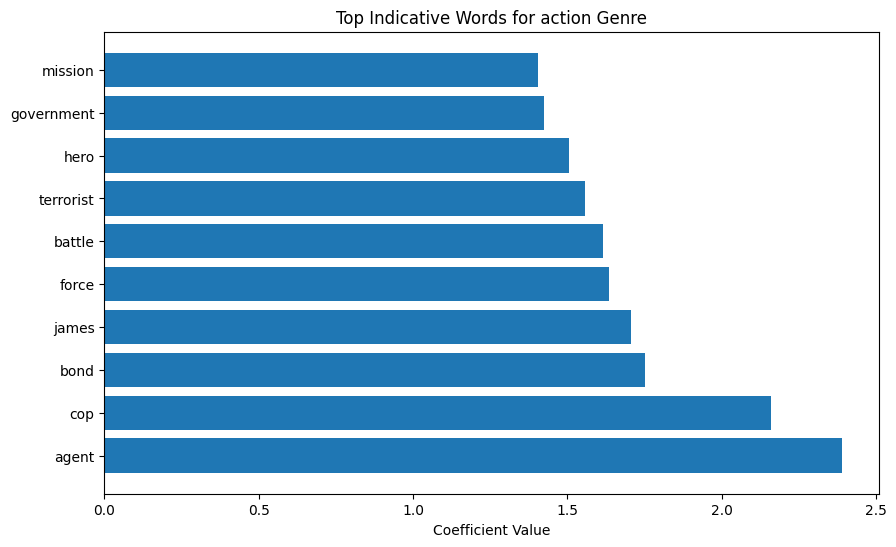

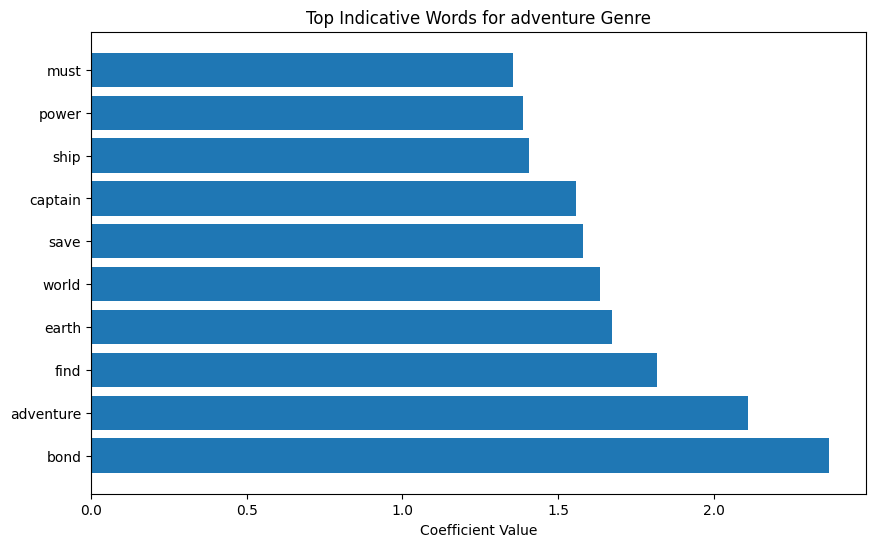

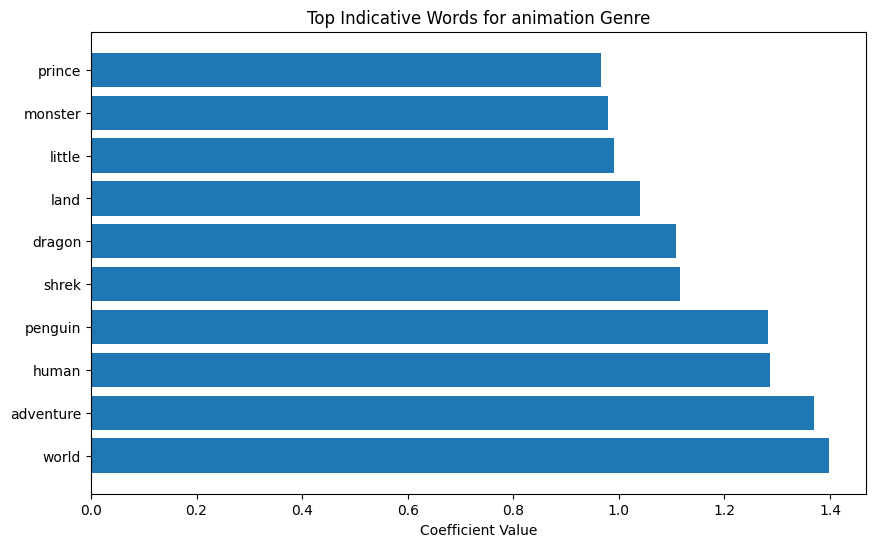

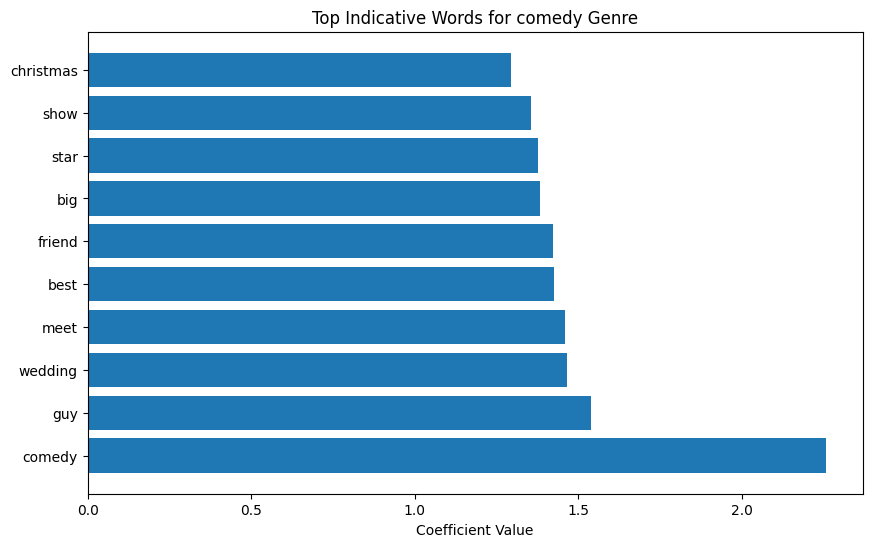

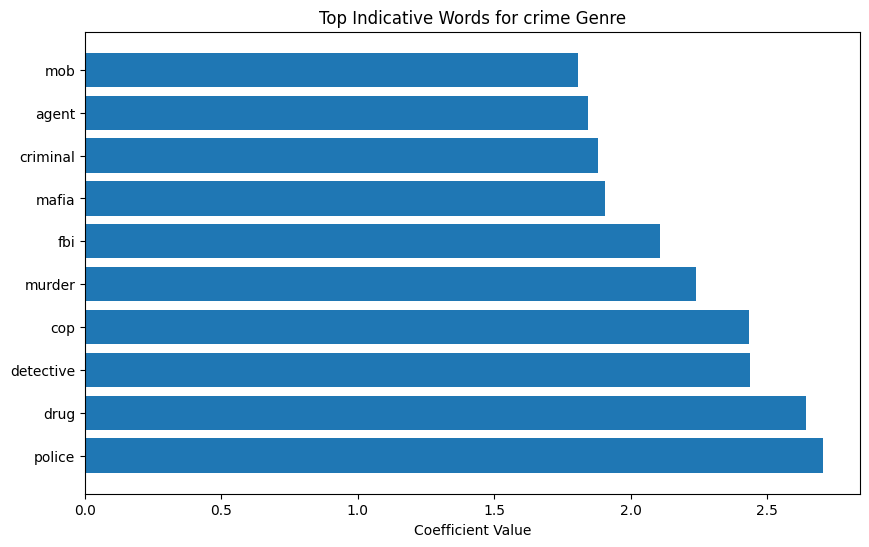

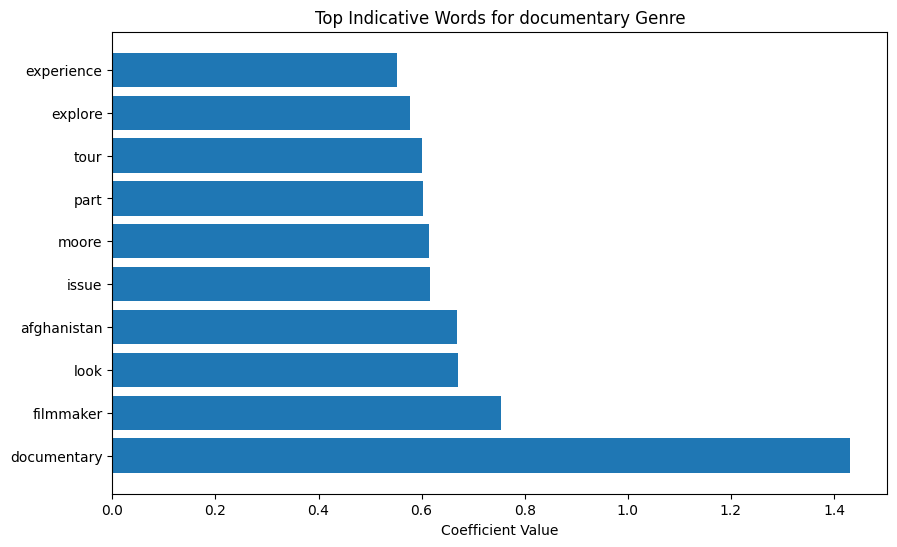

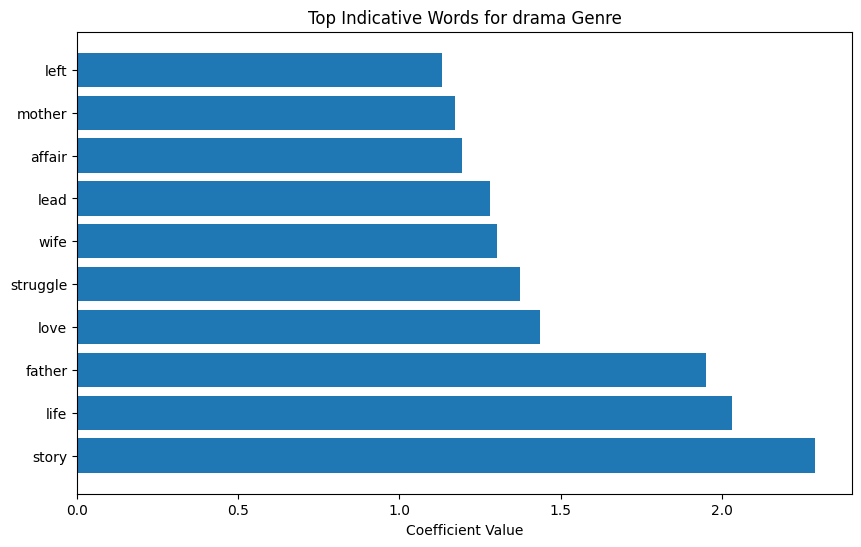

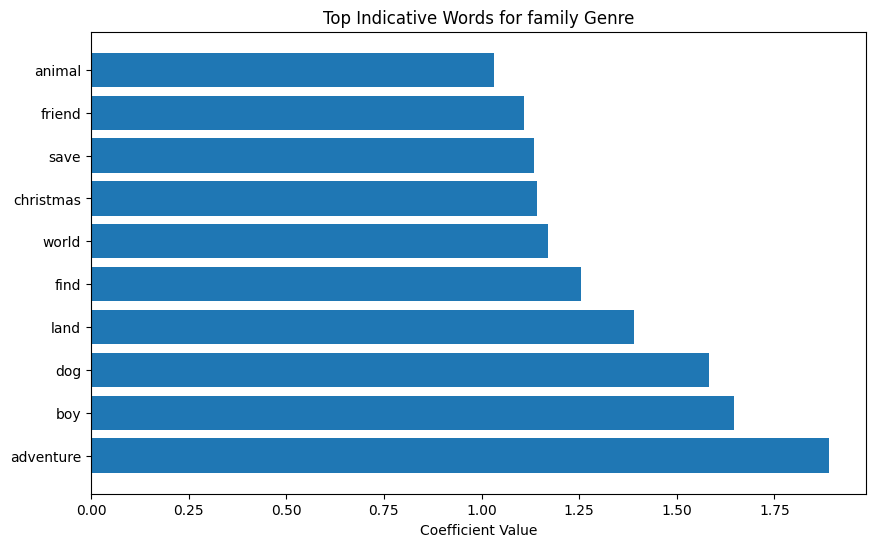

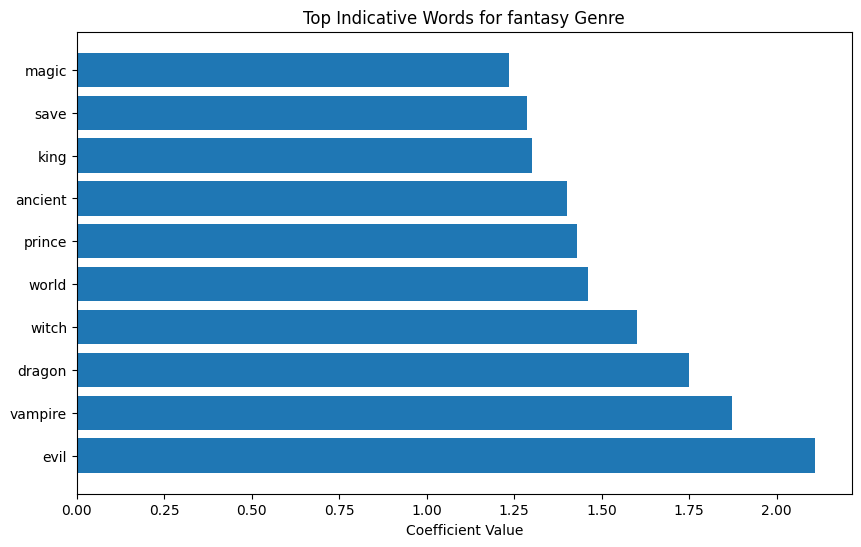

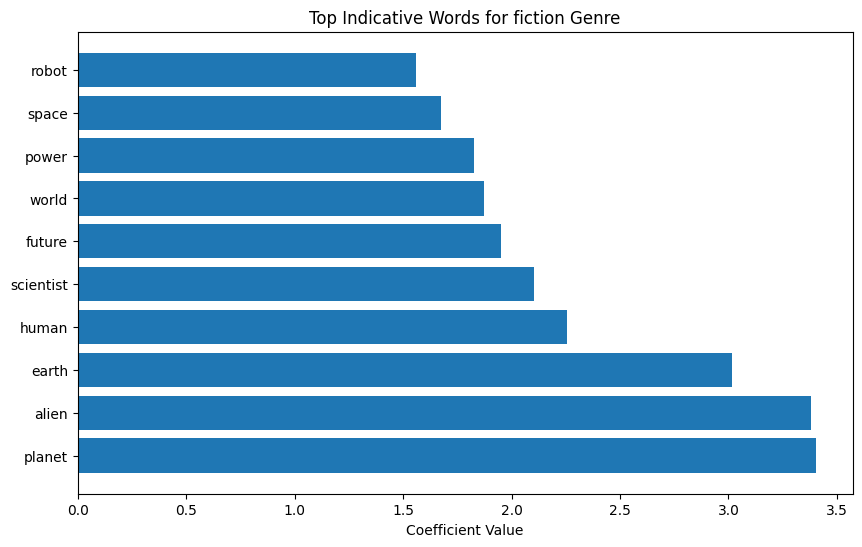

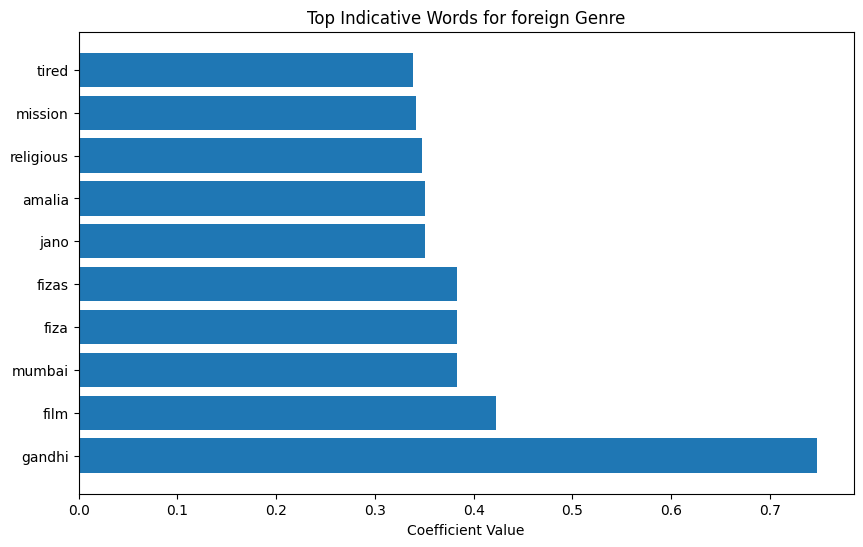

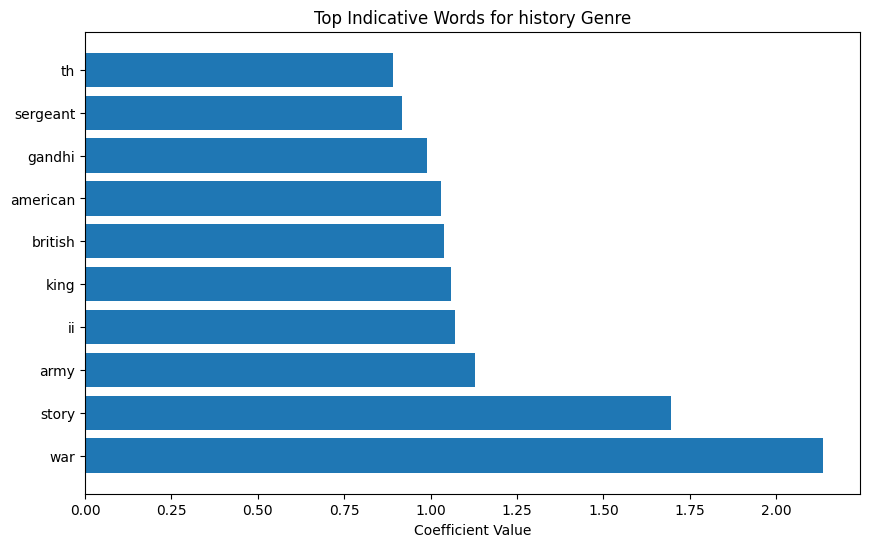

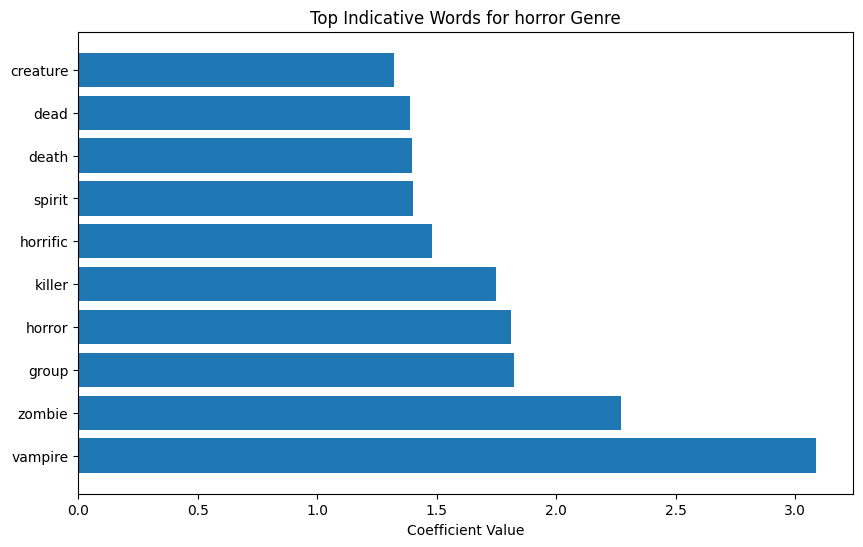

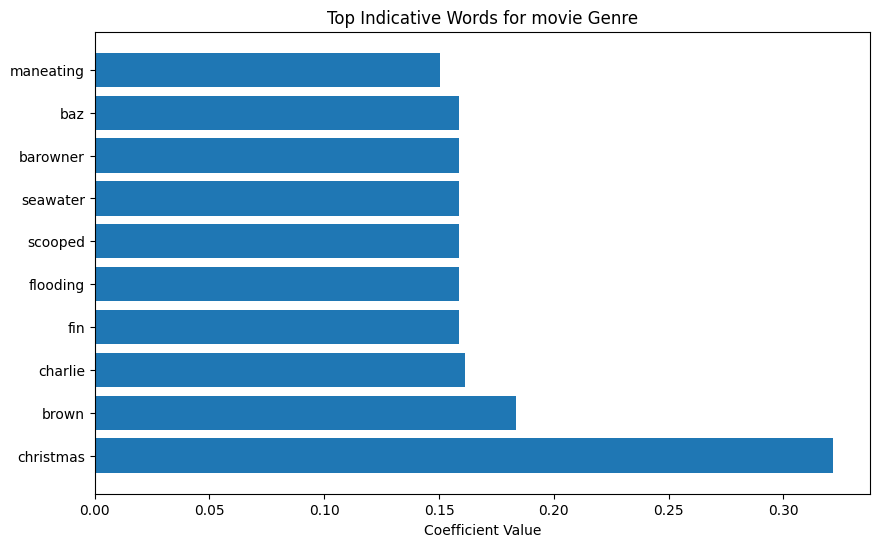

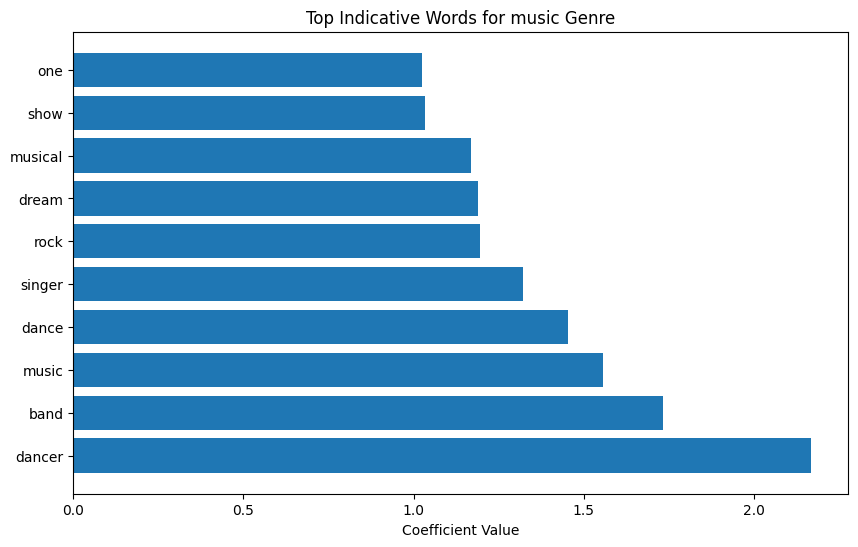

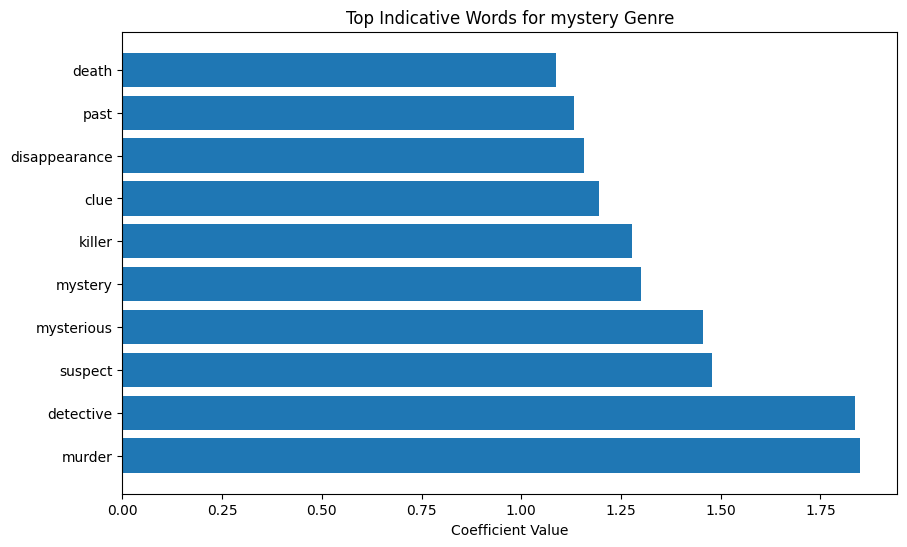

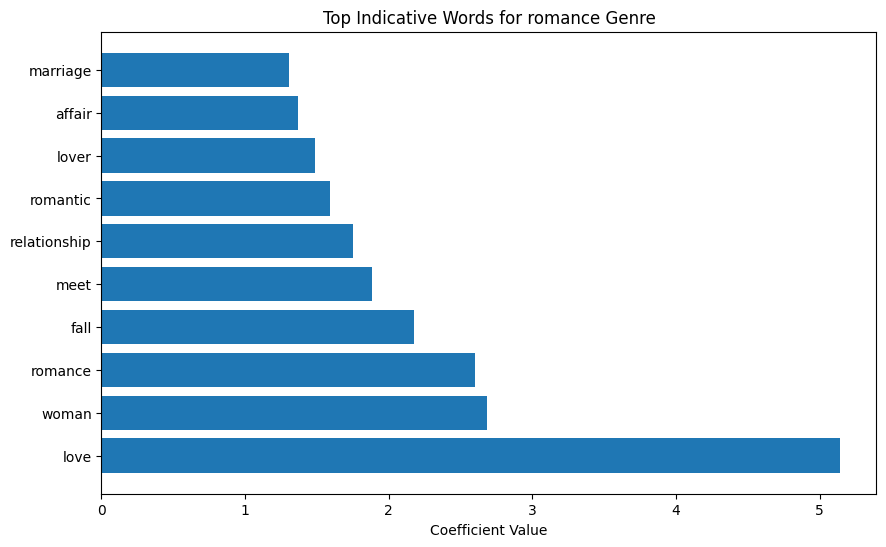

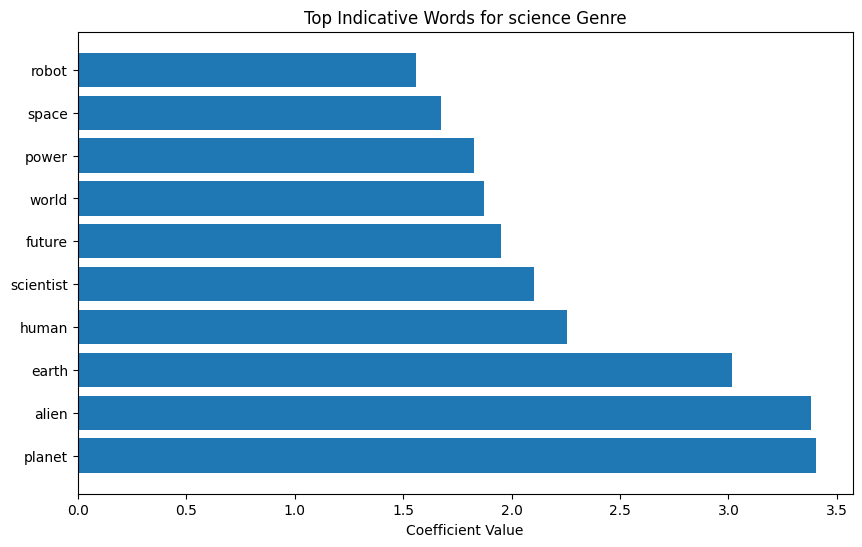

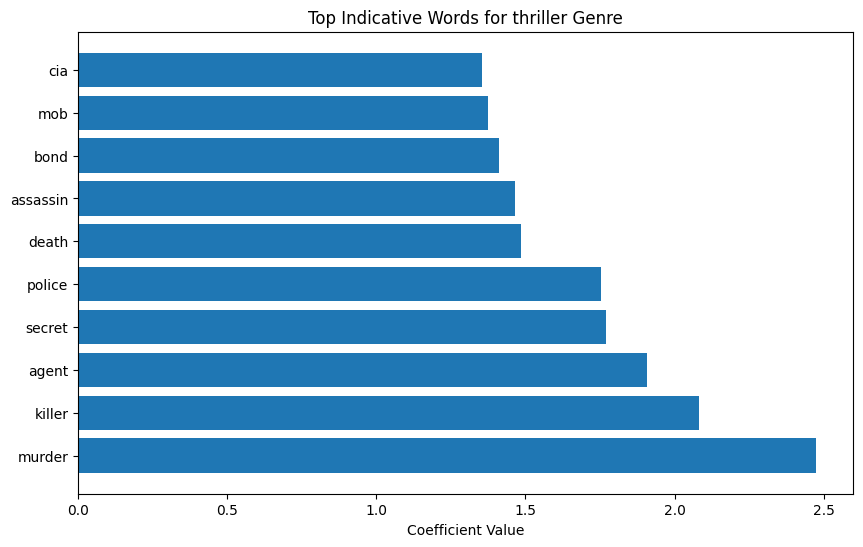

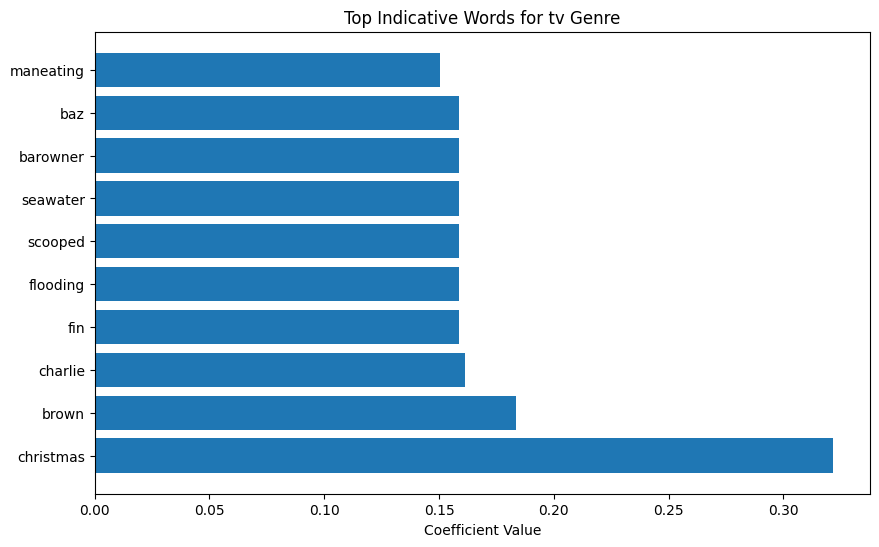

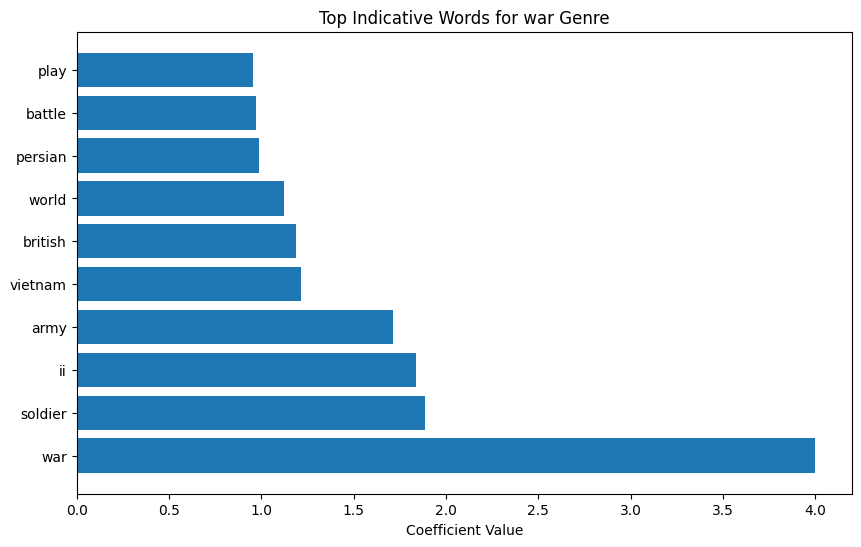

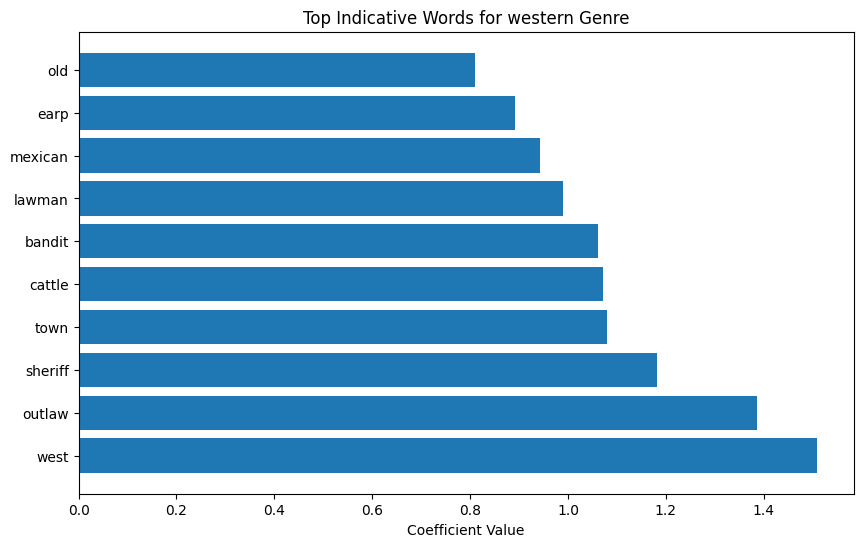

In [67]:
# For each genre, report 10 indicative words and provide a short interpretation explaining why they suggest that genre.
for genre, model in logistic_models.items():
    top_indices = np.argsort(model.coef_[0])[-10:]
    top_words = [tfidf_vectorizer.get_feature_names_out()[idx] for idx in top_indices]
    print(f"Genre: {genre}")
    print(f"Top indicative words: {top_words}")
    print(f"Interpretation: The presence of words like {', '.join(top_words)} may suggest themes or elements commonly associated with the {genre} genre, such as specific settings, character types, or plot devices.")

# Createing better visualizations to present the results. I will create bar charts to visualize the top indicative words for each genre, showing their corresponding coefficients from the logistic regression model.
import matplotlib.pyplot as plt
for genre, model in logistic_models.items():
    top_indices = np.argsort(model.coef_[0])[-10:]
    top_words = [tfidf_vectorizer.get_feature_names_out()[idx] for idx in top_indices]
    top_coefficients = model.coef_[0][top_indices]
    
    plt.figure(figsize=(10, 6))
    plt.barh(top_words, top_coefficients)
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Indicative Words for {genre} Genre')
    plt.gca().invert_yaxis()
    plt.show()